# Train model

Train and fine-tune a headless MobileNet V3 on a target image dataset directory

## Config

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import sqlalchemy as sqa
from typing import Callable
from collections import Counter
from scipy.stats import entropy

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
# PARAMETERS
# Model Parameters
image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2
shuffle_buffer = 50

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.00001
}

fine_tune_unfreeze_frac = 0.3

class_weight_defaults = {
    'positive': 1,
    'negative': 1,
    'negative_similar_plant': 0.9,
    'negative_random_picture': 0.7,
    'negative_general_plant': 0.8,
}


# Data parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"

class_weights = {} # TODO use class weights

metadata_tbl = "base_images"
datasets_tbl = "datasets"
dataset_img_tbl = "dataset_images"

# dataset_name = "all_v1_multiclass"
dataset_name = "test_multi_example"
# dataset_name = "test_bin_example"


# Output parameters
dataset_img_path = f"../datasets/pipeline_v1/{dataset_name}_pipeline/"

In [3]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

input_shape = (*image_size, 3)

In [4]:
with db_engine.connect() as con:
    df_dataset = pd.read_sql_query(f"""
                                   SELECT * FROM {datasets_tbl}
                                   WHERE name = '{dataset_name}'
                                   """, con, index_col='name')
    df_imgs = pd.read_sql_query(f"""
                                SELECT * FROM {dataset_img_tbl}
                                LEFT JOIN {metadata_tbl} ON {dataset_img_tbl}.image_name = {metadata_tbl}.image_name
                                WHERE dataset_name = '{dataset_name}'
                                """
                                , con, index_col='image_name')
    
ds_config = df_dataset.loc[dataset_name].to_dict()
ds_config['has_test'] = ds_config['test_frac'] > 0
ds_config['has_val'] = ds_config['validation_frac'] > 0
ds_config

{'target_dir': '/home/code/datasets/pipeline_v1/test_multi_dataset',
 'description': 'First example with 50 values from each class and multiclass labeling',
 'validation_frac': 0.2,
 'test_frac': 0.0,
 'label_method': 'MULTI',
 'has_test': False,
 'has_val': True}

In [5]:
train_dir = os.path.join(ds_config['target_dir'], 'train')
test_dir = os.path.join(ds_config['target_dir'], 'test')
val_dir = os.path.join(ds_config['target_dir'], 'validation')

## Datasets

In [6]:
def _get_image_name(img_path: str):
    """
    Convert image path to appropriate label
    """
    return(Path(img_path).name.replace("'", ""))

def label_tf_image_dataset(img_ds: tf.data.Dataset,
                           label_func: Callable[[str], str] = _get_image_name,
                           batch_size: int = batch_size) -> tf.data.Dataset:
    """
    Zips an image dataset (images, class_labels) with their image file names
    Works on unshuffled datasets & batch sizes must match
    Returns a dataset like ((images, class_labels), image_names)
    """
    img_labels = [label_func(img_path) for img_path in img_ds.file_paths]
    return tf.data.Dataset.zip((
        img_ds,
        tf.data.Dataset.from_tensor_slices(img_labels).batch(batch_size)
    ))
AUTOTUNE = tf.data.AUTOTUNE


# Make datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            label_mode='categorical')
class_names = train_dataset.class_names
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = None
if ds_config['has_val']:
    val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = None
if ds_config['has_test']:
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 160 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


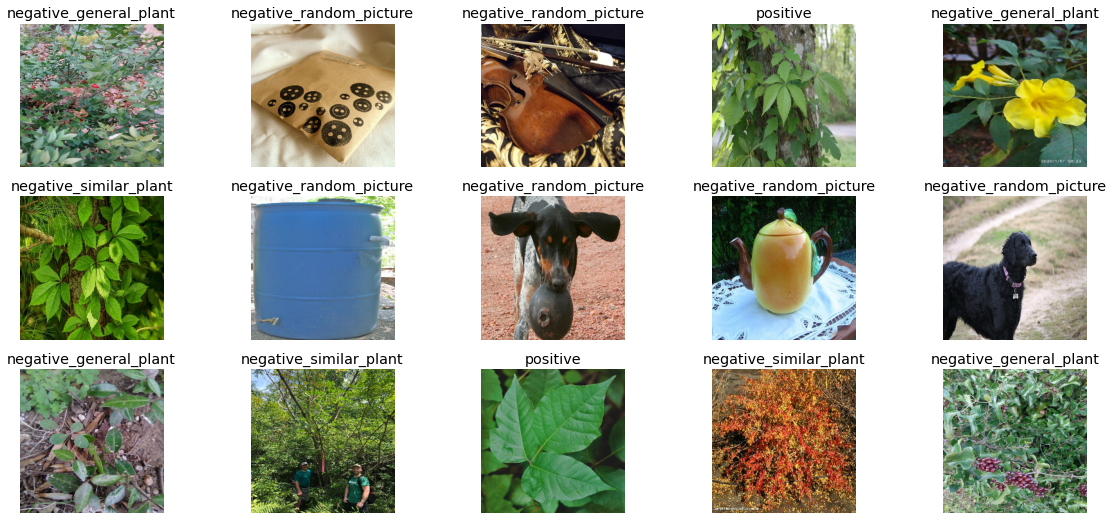

In [7]:
# TODO: fix so this takes from many class label?
n_classes = len(class_names)
y_ims = 3
x_ims = 5

plt.figure(figsize=(x_ims*4, y_ims*3))
for images, labels in train_dataset.take(1):
  for i in range(y_ims*x_ims):
    ax = plt.subplot(y_ims, x_ims, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

In [8]:
class_weights = {
    i: class_weight_defaults[class_name]
    for i, class_name in enumerate(class_names)
}
print(class_weights)

{0: 0.8, 1: 0.7, 2: 0.9, 3: 1}


## Processing layers

In [9]:

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


### Image augmentation

In [10]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [11]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [12]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    return(Model(inputs, outputs))
    

In [13]:
model = build_model(mobilenet_large)

In [14]:
model.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(patience=12, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=4, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [17]:
kwargs = {
    'epochs': epochs['top_layer'],
    'callbacks': callbacks
}
if ds_config['has_val']:
    kwargs['validation_data'] = val_dataset

history = model.fit(train_dataset, class_weight=class_weights, **kwargs)
print("MODEL COMPLETE")

Epoch 1/500
10/10 [==============================] - 7s 196ms/step - loss: 1.2356 - accuracy: 0.2625 - val_loss: 1.2940 - val_accuracy: 0.3750
Epoch 2/500
10/10 [==============================] - 1s 49ms/step - loss: 0.9302 - accuracy: 0.5000 - val_loss: 1.1213 - val_accuracy: 0.5000
Epoch 3/500
10/10 [==============================] - 1s 47ms/step - loss: 0.7687 - accuracy: 0.6000 - val_loss: 1.0595 - val_accuracy: 0.6250
Epoch 4/500
10/10 [==============================] - 1s 55ms/step - loss: 0.6429 - accuracy: 0.7625 - val_loss: 1.0253 - val_accuracy: 0.6000
Epoch 5/500
10/10 [==============================] - 1s 52ms/step - loss: 0.5483 - accuracy: 0.8188 - val_loss: 0.9990 - val_accuracy: 0.6250
Epoch 6/500
10/10 [==============================] - 1s 52ms/step - loss: 0.4921 - accuracy: 0.8375 - val_loss: 0.9862 - val_accuracy: 0.6500
Epoch 7/500
10/10 [==============================] - 1s 54ms/step - loss: 0.4462 - accuracy: 0.8500 - val_loss: 0.9539 - val_accuracy: 0.6750
Epoch

## Fine-tune models

In [18]:
unfreeze = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-large: Unfreezing {unfreeze} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze]:
    layer.trainable = False

Mobilenet-large: Unfreezing 81 of 270 layers


In [19]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [20]:
model.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
print(len(history.epoch))

22


In [22]:
base_epochs = len(history.epoch)
history_FT = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=epochs['fine_tuning'] + base_epochs,
                       initial_epoch=history.epoch[-1],
                       callbacks=callbacks,
                       class_weight=class_weights)

Epoch 22/522
10/10 [==============================] - 6s 161ms/step - loss: 0.1778 - accuracy: 0.9438 - val_loss: 0.9226 - val_accuracy: 0.7000
Epoch 23/522
10/10 [==============================] - 1s 75ms/step - loss: 0.1470 - accuracy: 0.9812 - val_loss: 0.9129 - val_accuracy: 0.7000
Epoch 24/522
10/10 [==============================] - 1s 74ms/step - loss: 0.1311 - accuracy: 0.9812 - val_loss: 0.9054 - val_accuracy: 0.7000
Epoch 25/522
10/10 [==============================] - 1s 79ms/step - loss: 0.1487 - accuracy: 0.9688 - val_loss: 0.9233 - val_accuracy: 0.7000
Epoch 26/522
10/10 [==============================] - 1s 73ms/step - loss: 0.1112 - accuracy: 0.9875 - val_loss: 0.9344 - val_accuracy: 0.7000
Epoch 27/522
10/10 [==============================] - 1s 75ms/step - loss: 0.0990 - accuracy: 0.9937 - val_loss: 0.9388 - val_accuracy: 0.7000
Epoch 28/522
10/10 [==============================] - 1s 78ms/step - loss: 0.1126 - accuracy: 0.9875 - val_loss: 0.9499 - val_accuracy: 0.700

## Analyze history

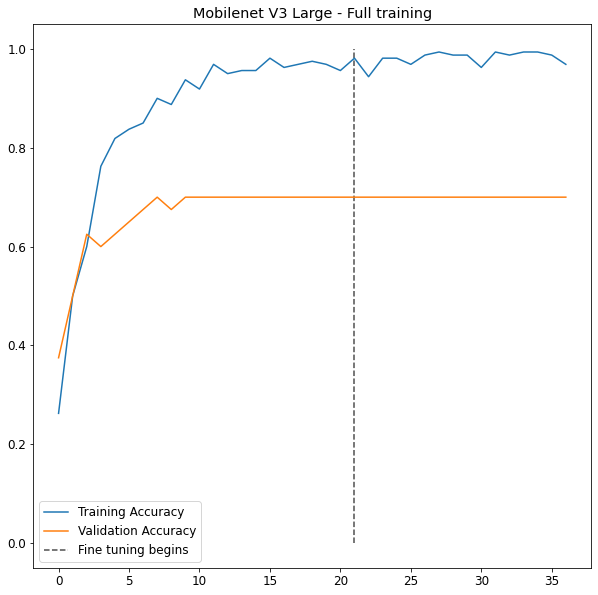

In [23]:
plt.figure(figsize=(10,10))

total_history = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history[metric] = history.history[metric] + history_FT.history[metric]

ax = plt.subplot(1,1,1)
plt.plot(total_history['accuracy'], label='Training Accuracy')
plt.plot(total_history['val_accuracy'], label='Validation Accuracy')
y_min, y_max = (0, 1)
plt.vlines(base_epochs-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


plt.show()

## Analyze results

In [24]:
POSITIVE = 'positive'
NEGATIVE = 'negative'
POSITIVE_IND = class_names.index(POSITIVE)

### Build results dataset

In [25]:
result_records = []
ds_splits = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
class_name_counts = Counter()

for split, dataset in ds_splits.items():
    if dataset is not None:
        for imgs, class_labels in dataset:
            probs = model.predict(imgs)
            class_values = class_labels.numpy().argmax(axis=1)
            for prob, class_val in zip(probs, class_values):
                pred = prob.argmax()
                class_name = class_names[class_val]
                class_name_counts[class_name] += 1
                img_name = class_name + '_' + str(class_name_counts[class_name])   # Count image within class to name it
                target_path = Path(Path(dataset_img_path).absolute().resolve(), img_name + '.jpg')

                record = {'ds_image_name': img_name,
                          'split': split,
                          'class_value': class_val,
                          'class_name': class_names[class_val],
                          'pred_val': pred,
                          'pred_probs': prob,
                          'pred_class': class_names[pred],
                          'is_positive': class_val == POSITIVE_IND,
                          'pred_positive': pred == POSITIVE_IND,
                          'binary_pred': POSITIVE if pred == POSITIVE_IND else NEGATIVE,
                          'binary_class': POSITIVE if class_val == POSITIVE_IND else NEGATIVE,
                          'positive_prob': prob[POSITIVE_IND],
                          'target_path': target_path}
                result_records.append(record)
df_res = pd.DataFrame(result_records).set_index('ds_image_name')
df_res['pred_entropy'] = df_res['pred_probs'].map(entropy)
del(result_records)
df_res.head()

,split,class_value,class_name,pred_val,pred_probs,pred_class,is_positive,pred_positive,binary_pred,binary_class,positive_prob,target_path,pred_entropy
ds_image_name,,,,,,,,,,,,,
positive_1,train,3,positive,3,"[0.005736337, 0.0003366096, 0.08014633, 0.9137...",positive,True,True,positive,positive,0.913781,/home/code/datasets/pipeline_v1/test_multi_exa...,0.316969
negative_general_plant_1,train,0,negative_general_plant,2,"[0.049045786, 0.021411095, 0.6992491, 0.23029399]",negative_similar_plant,False,False,negative,negative,0.230294,/home/code/datasets/pipeline_v1/test_multi_exa...,0.818493
positive_2,train,3,positive,3,"[0.14880057, 0.008774505, 0.019539598, 0.8228854]",positive,True,True,positive,positive,0.822885,/home/code/datasets/pipeline_v1/test_multi_exa...,0.562349
positive_3,train,3,positive,3,"[0.002475643, 6.7547095e-05, 0.0017405614, 0.9...",positive,True,True,positive,positive,0.995716,/home/code/datasets/pipeline_v1/test_multi_exa...,0.030839
positive_4,train,3,positive,3,"[0.009258937, 9.318642e-05, 0.014462869, 0.976...",positive,True,True,positive,positive,0.976185,/home/code/datasets/pipeline_v1/test_multi_exa...,0.129013


In [26]:
conf_matrix = (
    df_res.groupby(['split', 'class_name', 'pred_class'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index=['split', 'class_name'], columns='pred_class', values='counts')
        .fillna(0)
        .astype('int')
)
conf_matrix

pred_class                     negative_general_plant  \
split class_name                                        
train negative_general_plant                       38   
      negative_random_picture                       0   
      negative_similar_plant                        0   
      positive                                      0   
val   negative_general_plant                        7   
      negative_random_picture                       1   
      negative_similar_plant                        2   
      positive                                      0   

pred_class                     negative_random_picture  \
split class_name                                         
train negative_general_plant                         0   
      negative_random_picture                       40   
      negative_similar_plant                         0   
      positive                                       0   
val   negative_general_plant                         0   
      negative_random_picture                        6   
      negative_similar_plant                         0   
      positive                                       0   

pred_class                     negative_similar_plant  positive  
split class_name                                                 
train negative_general_plant                        2         0  
      negative_random_picture                       0         0  
      negative_similar_plant                       39         1  
      positive                                      0        40  
val   negative_general_plant                        3         0  
      negative_random_picture                       2         1  
      negative_similar_plant                        5         3  
      positive                                      0        10

In [27]:
conf_matrix_binary = (
    df_res.groupby(['split', 'binary_class', 'binary_pred'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index=['split', 'binary_class'], columns='binary_pred', values='counts')
        .fillna(0)
        .astype('int')
)
conf_matrix_binary

binary_pred         negative  positive
split binary_class                    
train negative           119         1
      positive             0        40
val   negative            26         4
      positive             0        10

In [ ]:
# TODO visualize analysis

## Store model

In [ ]:
# TODO store model